# Semantic segmentation with scikit-learn

Cliassifying every pixel in your image

> Written by Dr Daniel Buscombe, Northern Arizona University

> Part of a series of notebooks for image recognition and classification using deep convolutional neural networks

This notebook demonstrates some strategies for semantic image segmentation using common machine learning techniques

## Naïve Bayes classification

Naive Bayes models are a group of extremely fast and simple classification algorithms that are often suitable for very high-dimensional datasets. Because they are so fast and have so few tunable parameters, they end up being very useful as a quick-and-dirty baseline for a classification problem. This section will focus on an intuitive explanation of how naive Bayes classifiers work, followed by a couple examples of them in action on some datasets.

Use it to predict pixels in images and if they are sand
No reaminders, everything gets classified. Us tat pixel but the ones around it to come up with a class
 

## Detection of sand using Naïve Bayes 

In this example, Naïve Bayes classification is employed to detect pixels corresponding to sand in images, based just in the pixels color.

##Training data is a M×N×3 array representing a color training image, and mask a M×N binary array representing the classification sand/non-sand. 

In [1]:
## Loading libraries and accessing file system
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
import s3fs
fs = s3fs.S3FileSystem(anon=True)

Let's read an image in and look at its distributions of red, green and blue values

In [2]:
##getting dimensions of data
with fs.open('cdi-workshop/semseg_data/sandbars/RC0307Rf_20131111_1347.JPG', 'rb') as f:
    training_rgb = imread(f)
M, N, _ = training_rgb.shape

Text(0.5,1,'Pixel values')

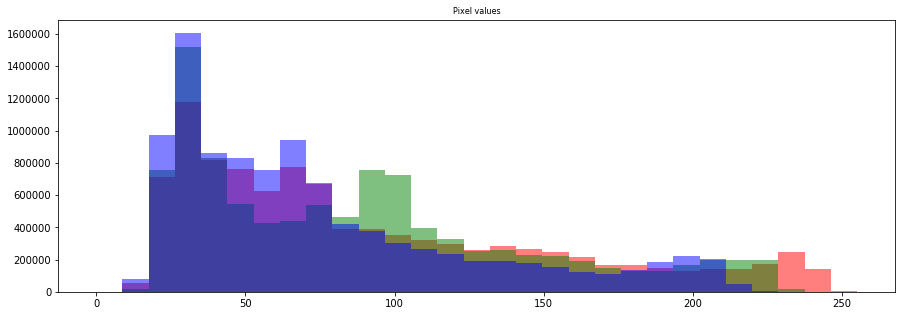

In [3]:
##plotting distributions of RGB pixels

bins = np.linspace(0,255,30)

plt.figure(figsize=(15,5))
hist = plt.hist(training_rgb[:,:,0].flatten(), bins=bins, color='r', alpha=0.5)
hist = plt.hist(training_rgb[:,:,1].flatten(), bins=bins, color='g', alpha=0.5)
hist = plt.hist(training_rgb[:,:,2].flatten(), bins=bins, color='b', alpha=0.5)
plt.title('Pixel values', fontsize=8)

An (overly) simplistic approach to finding sand in a given image would be to find some threshold intensity in a certain channel

using all the information not going gray scale

In [4]:
## just assuming the intensity of sand is always greater than 200 in the red channel
threshold = 200

mask = np.zeros((M,N))
## threshold of 1 is thats where there is sand, so basically binary
mask[training_rgb[:,:,0] > threshold] = 1

(-0.5, 3887.5, 2591.5, -0.5)

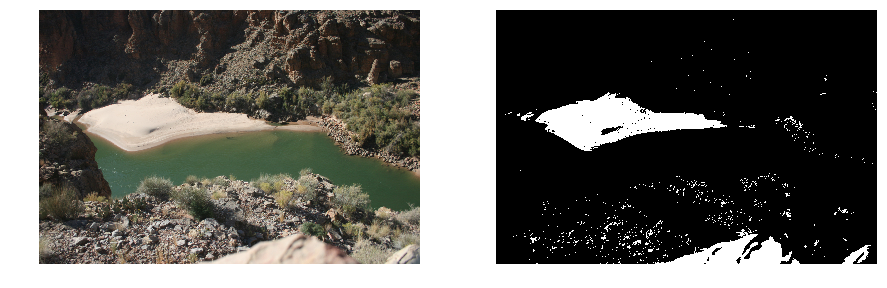

In [5]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(training_rgb)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask, cmap=plt.cm.binary_r)
plt.axis('off')

In [ ]:
## For many images need to create masks for each one and then concatenate into three columns again.

THe image above is the mask that shows where sand was using the thresholding

The data is composed by MN 3d-vectors of red, green and blue values

reshape the data so columns and rows are concatenated into 1 and leaving other three

In [7]:
print(np.shape(training_rgb))
data = training_rgb.reshape(M*N, -1)[:,:]
print(np.shape(data))

(2592, 3888, 3)
(10077696, 3)


The classification used in the learning step is represented as a binary MN vector

In [8]:

## super simple N of 1
target = mask.reshape(M*N)
target

array([0., 0., 0., ..., 0., 0., 0.])

### Training (fitting)

Sklearn provides a naive_bayes module containing a GaussianNB object that implements the supervised learning by the Gaussian Naïve Bayes method. 

One extremely fast way to create a simple model is to assume that the data is described by a Gaussian distribution with no covariance between dimensions. This model can be fit by simply finding the mean and standard deviation of the points within each label, which is all you need to define such a distribution.

In [11]:

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(data, target)

GaussianNB(priors=None)

### Testing

Sand detection can be performed by reshaping and slicing in the same way as the training image. 

The predict method of GaussianNB performs the classification. The resulting classification vector can be reshaped to the original image dimensions for visualization.

Let's test at an image from the same place but at a different time

In [12]:
## load a test image in
with fs.open('cdi-workshop/semseg_data/sandbars/RC0307Rf_20161106_1157.JPG', 'rb') as f:
    test_rgb = imread(f)
M_tst, N_tst, _ = test_rgb.shape

In [13]:
## Again reshaping the model expects all blue pixels in one column, green in another and red in another
data = test_rgb.reshape(M_tst * N_tst, -1)[:,:]
sand_pred = gnb.predict(data)
S = sand_pred.reshape(M_tst, N_tst)

(-0.5, 3887.5, 2591.5, -0.5)

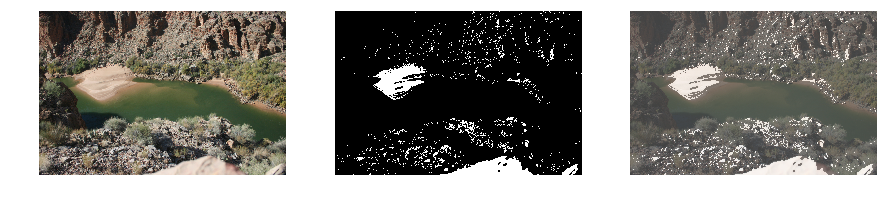

In [14]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(test_rgb)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(S, cmap=plt.cm.binary_r)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(test_rgb, alpha=0.6)
plt.imshow(S, cmap=plt.cm.binary_r, alpha=0.4)
plt.axis('off')

Import image, where it thinks the sand is, and corendered. He thinks its terrible because picked up more than just sand bar

We can also estimate the probabilities of each class because we have a simple recipe to compute the likelihood $P({\rm features}~|~L_1)$ for any data point, and thus we can quickly compute the posterior ratio and determine which label is the most probable for a given point.

In [16]:
##this time we are looking at probability of sand
sand_pred = gnb.predict_proba(data)
Sprob = sand_pred.reshape(M_tst, N_tst, -1)

And plot the probabilities:

Text(0.5,1,'Probability of Sand')

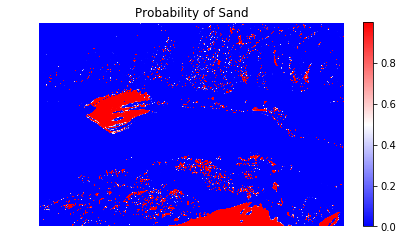

In [17]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(Sprob[:,:,1], cmap=plt.cm.bwr)
plt.axis('off')
plt.colorbar(shrink=0.25)
plt.title('Probability of Sand')

In [ ]:
## not very useful because it predicted with almost a 1 every place it predicted sand. 

(-0.5, 3887.5, 2591.5, -0.5)

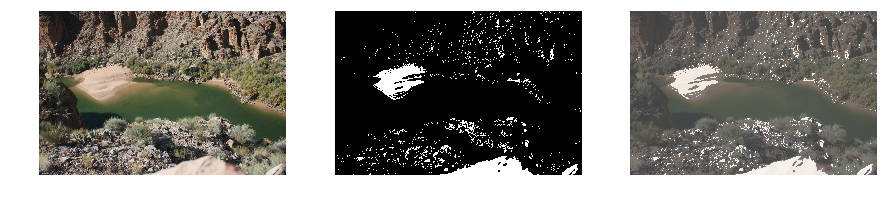

In [18]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(test_rgb)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(S, cmap=plt.cm.binary_r)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(test_rgb, alpha=0.6)
## just show probabilities of more than 99%, doesn't do very well for us because predicts 1 almost everywhere is predicted
plt.imshow(Sprob[:,:,1]>.99, cmap=plt.cm.binary_r, alpha=0.4)
plt.axis('off')

Now let's try the classifier from an image taken at a different place

Lets see how bad it continues to be

In [19]:
with fs.open('cdi-workshop/semseg_data/sandbars/RC0220Ra_20150219_1126.JPG', 'rb') as f:
    test_rgb = imread(f)

M_tst, N_tst, _ = test_rgb.shape

In [20]:
data = test_rgb.reshape(M_tst * N_tst, -1)[:,:]
sand_pred = gnb.predict(data)
S = sand_pred.reshape(M_tst, N_tst)

(-0.5, 3887.5, 2591.5, -0.5)

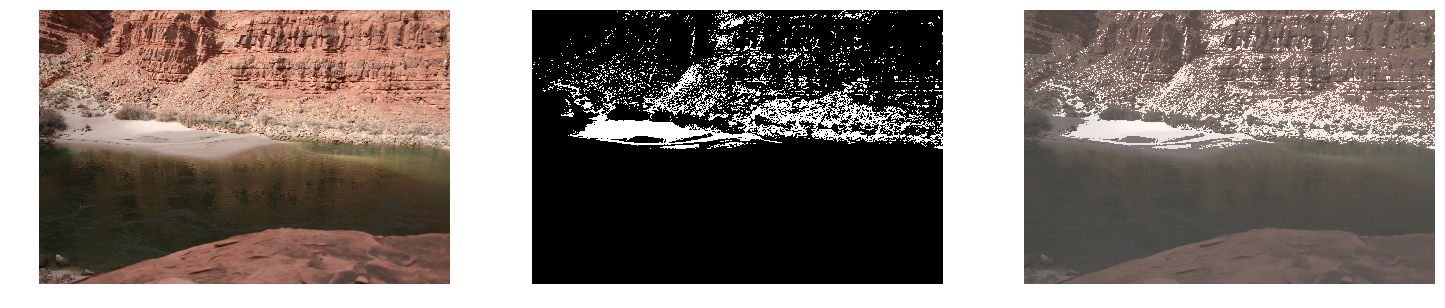

In [21]:
plt.figure(figsize=(25,15))
plt.subplot(1,3,1)
plt.imshow(test_rgb)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(S, cmap=plt.cm.binary_r)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(test_rgb, alpha=0.6)
plt.imshow(S, cmap=plt.cm.binary_r, alpha=0.4)
plt.axis('off')

In [ ]:
## so still finds sand but not accurate enough

Not great. Because naive Bayesian classifiers make such stringent assumptions about data, they will generally not perform as well as a more complicated model. 

## Naive Bayes with principal components

We can make things more complicated by
* adding more classes
* using feature extraction

Unlike before, we can build the feature extraction straight into the model using pipelines, which sequentially apply a list of transforms and a final estimator. In our case we'll use PCA as a transform again

So like before take an image decompose it into PC and then run it again 

In [22]:
from sklearn.decomposition import PCA 
from sklearn.pipeline import make_pipeline

##n_components is 3 PC and piping it directly into the classifier
pca = PCA(svd_solver='randomized', n_components=3, whiten=True, random_state=42)
model = make_pipeline(pca, gnb)

Arbitrary thresholds can be made to make classes based on intensity alone

In [23]:
data = training_rgb.reshape(M*N, -1)[:,:]

threshold_sand = 200
threshold_shadow = 60
threshold_rock = 100

## sand is classified as 3, shadow is 0 and 1 and 2 are rocks and other
mask = np.zeros((M,N))
mask[training_rgb[:,:,0] > threshold_sand] = 3
mask[training_rgb[:,:,0] < threshold_shadow] = 0
mask[(training_rgb[:,:,0] > threshold_rock) & (training_rgb[:,:,0] < threshold_sand) ] = 1
mask[(training_rgb[:,:,0] > threshold_shadow) & (training_rgb[:,:,0] < threshold_rock) ] = 2

(-0.5, 3887.5, 2591.5, -0.5)

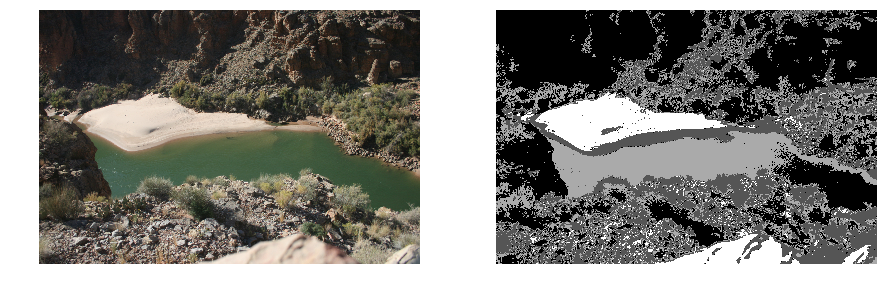

In [24]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(training_rgb)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask, cmap=plt.cm.binary_r)
plt.axis('off')

In [ ]:
## do same thing again with four classes and PCA

In [25]:
target = mask.reshape(M*N)
model.fit(data, target)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=3, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=True)), ('gaussiannb', GaussianNB(priors=None))])

Apply model to the test image and plot the result:

In [26]:
data = test_rgb.reshape(M_tst * N_tst, -1)[:,:]
sand_pred = model.predict(data)
S = sand_pred.reshape(M_tst, N_tst)

(-0.5, 3887.5, 2591.5, -0.5)

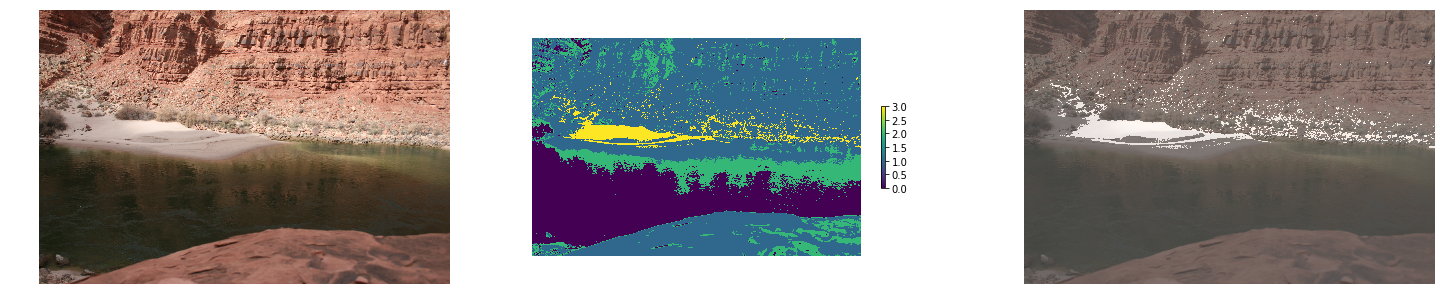

In [27]:
plt.figure(figsize=(25,15))
plt.subplot(1,3,1)
plt.imshow(test_rgb)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(S) #, cmap=plt.cm.binary_r)
plt.axis('off')
plt.colorbar(shrink=0.1)
plt.subplot(1,3,3)
plt.imshow(test_rgb, alpha=0.6)
plt.imshow(S==3, cmap=plt.cm.binary_r, alpha=0.4)
plt.axis('off')

In this case, there wasn't much advantage using feature extraction with the NB model. Let's look at a different model

## Gaussian Mixture Model

Specifying thresholds is a big weakness. There are other approaches that attempt to estimate the decision boundaries between different classes. One example is a Gaussian Mixture Model.

In [28]:
from sklearn.mixture import GaussianMixture

We're going to use downscaled versions of images to speed up the process

In [29]:
##so we want to identify boundaries between classes using GMM
## loading in training and testing and downsampling to save time
from scipy.misc import imresize
with fs.open('cdi-workshop/semseg_data/sandbars/RC0307Rf_20131111_1347.JPG', 'rb') as f:
    training_rgb = imresize(imread(f), .125)
    
with fs.open('cdi-workshop/semseg_data/sandbars/RC0220Ra_20150219_1126.JPG', 'rb') as f:
    test_rgb = imresize(imread(f), .125)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Fit the model with 4 components to the data, 1 can be sand and the other 3 will be other things

In [31]:
M, N, _ = training_rgb.shape
##reshape models into 3 columns
data = training_rgb.reshape(M*N, -1)[:,:]
## Fit into 4 components as best you can
## tied is will tell you covariance and apply it to the rest of the data
gmm = GaussianMixture(n_components=4, covariance_type="tied").fit(data)
labels = gmm.predict(data)

GMMs use an expectation–maximization approach which qualitatively does the following:

Choose starting guesses for the location and shape

Repeat until converged:

* E-step: for each point, find weights encoding the probability of membership in each cluster
* M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights

We'll only show every 10th data point to save time

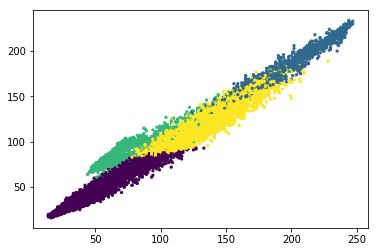

In [32]:
## the first number is red and the secoind is green
plt.scatter(data[::10, 0], data[::10, 1], c=labels[::10], s=5, cmap='viridis');

a plot of 5 different lables only using red and green channels in the data.
Able to cluster data so no longer just 1 or 0. 


Apply to a new test image and plot

In [34]:
newdata = test_rgb.reshape(M * N, -1)[:,:]
cluster = gmm.predict(newdata)
cluster = cluster.reshape(M, N)

(-0.5, 485.5, 323.5, -0.5)

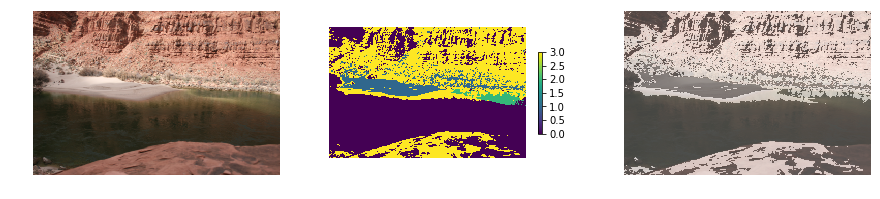

In [35]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(test_rgb)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(cluster) #, cmap=plt.cm.binary_r)
plt.axis('off')
plt.colorbar(shrink=0.1)
plt.subplot(1,3,3)
plt.imshow(test_rgb, alpha=0.6)
plt.imshow(cluster==3, cmap=plt.cm.binary_r, alpha=0.4)
plt.axis('off')

In [ ]:
## middle is semantic segmentation

Because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the predict_proba method. This returns a matrix of size [n_samples, n_clusters] which measures the probability that any point belongs to the given cluster:

In [36]:
## posterior probability
post_probs = gmm.predict_proba(newdata)
np.shape(post_probs)

(157464, 4)

Text(0.5,1,'Probability of Sand')

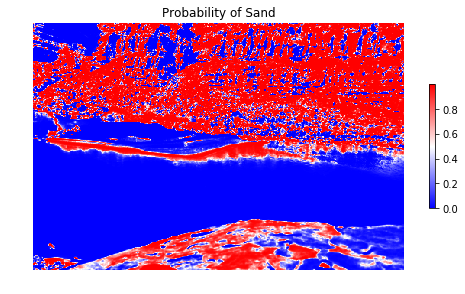

In [37]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.imshow(post_probs[:,3].reshape(M, N), cmap=plt.cm.bwr)
plt.axis('off')
plt.colorbar(shrink=0.5)
plt.title('Probability of Sand')

In [ ]:
## not very good because it gives a high probability not to sand

### How many components?

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset. A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the likelihood of the data under the model, using cross-validation to avoid over-fitting. 

Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the Akaike information criterion (AIC) or the Bayesian information criterion (BIC). Scikit-Learn's GMM estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

In [38]:
## running through 2 components up to 15 and see which one makes the best predicition
n_components = np.arange(2, 15)
models = [GaussianMixture(n, covariance_type='tied', random_state=0).fit(data)
          for n in n_components]

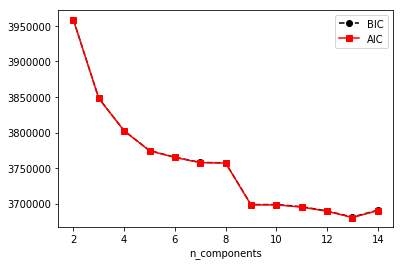

In [39]:
plt.plot(n_components, [m.bic(data) for m in models], 'k--o', label='BIC')
plt.plot(n_components, [m.aic(data) for m in models], 'r-s', label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In this case, AIC and BIC are the same

The optimal number of clusters is the value that minimizes the AIC or BIC. 

It says about 9 components would have been a better choice than 4

The lowest score is the best, so 2 components is terrible in this case the aic and bic are the same. So the NUmber of components can use 9 components because is low but less complicated than 14. So below we do the same thing with 9 components

In [40]:
gmm = GaussianMixture(n_components=9, covariance_type="tied").fit(data)

In [41]:
newdata = test_rgb.reshape(M * N, -1)[:,:]
cluster = gmm.predict(newdata)
cluster = cluster.reshape(M, N)

We can look at the means for each cluster

In [42]:
print(gmm.means_[1])

[191.90016713 178.20625707 162.541068  ]


In [43]:
print(gmm.means_[3])

[108.60026376  98.49278908  80.36664419]


In [44]:
sorted_means = np.argsort(np.mean(gmm.means_, axis=1))
sorted_means

array([4, 7, 0, 6, 3, 8, 2, 1, 5])

(-0.5, 485.5, 323.5, -0.5)

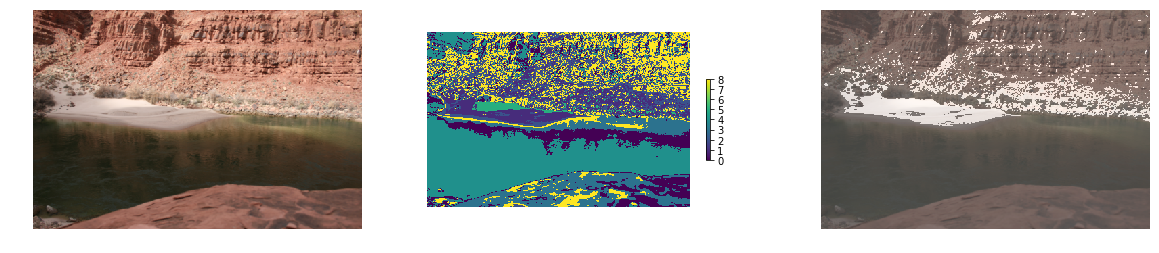

In [45]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(test_rgb)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(cluster) 
plt.axis('off')
plt.colorbar(shrink=0.15)
plt.subplot(1,3,3)
plt.imshow(test_rgb, alpha=0.6)
plt.imshow((cluster==sorted_means[-1])  + (cluster==sorted_means[-2]), cmap=plt.cm.binary_r, alpha=0.4)
plt.axis('off')

Looks like one cluster represents lower beach and another cluster represents upper beach

What choices did we make to arrive at this result?
* which cluster corresponds to what feature
* number of components
* type of covariance

How well does this approach generalize to all sandbar images?

## Exercises

1. Training a classifier with ground truth imagery

We'll use the seabright dataset for this task. We have images and associated ground-truth labelled imagery

First, we'll load in the images (downsizng them to aid with speed)

In [46]:
## seabright data set has an associated data file with a label
images = [f for f in fs.ls('cdi-workshop/semseg_data/seabright/train') if f.endswith('.jpg')]
len(images)

Xtrain = []
for file in images:
    with fs.open(file, 'rb') as f:
        Xtrain.append(imresize(imread(f), .125))

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Next we'll load the label images, contained in .mat files

We need to rescale these data the same way as we rescaled the imagery, but this time we also need to make sure that we keep the label images in whole integeres

In [47]:
## Loading data in and downsampling for the sake of speed. Each pixel in these data is coded into 
## 8 different classes
from scipy.io import loadmat

classfiles = [f for f in fs.ls('cdi-workshop/semseg_data/seabright/train/gt') if f.endswith('.mat')]

ytrain = []
for file in classfiles:
    with fs.open(file) as f:
        dat = loadmat(f)['class']
        datr = np.round(imresize(dat, .125, interp='nearest')/255 * np.max(dat))
        ytrain.append(datr)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Always a good idea to plot some data just to check it is as you expect

(-0.5, 919.5, 613.5, -0.5)

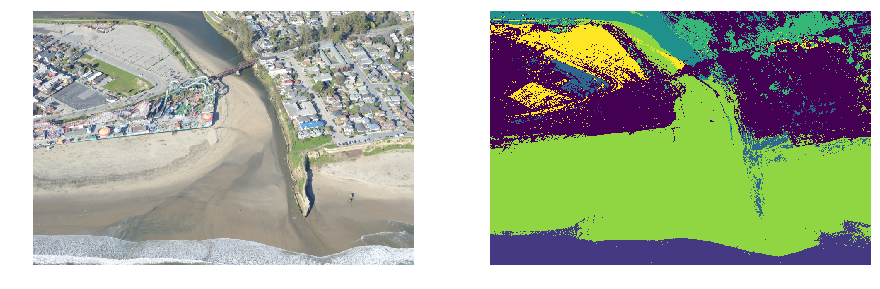

In [48]:
plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(Xtrain[0]); plt.axis('off')
plt.subplot(122); plt.imshow(ytrain[0]); plt.axis('off')

In [49]:
num_images, M, N, num_channels = np.shape(Xtrain)

Ok, go ahead and fit a Naive Bayes model to the first pair of images

In [ ]:
## the same as we did before with reshape and using 1 training (masking) image against 1 testing image


Using that model, predict the labels for the next image in the sequence

In [ ]:
##xtrain[1] is how well to we predict on one image

Make a 4-part plot showing 
1. the original image 
2. the original label image
3. the model-predicted label image
4. the pixels associated with water

How well does it do?

So that was a single training data image now we will use the whole dataset

In order to fit a model to the entire dataset, we need to arrange the data a little different

The model fitting function expected the image data to be arranged N_features x N_channels (3)

and the label data to be 

N_features 

In [50]:
X = []
for item in Xtrain:
    X.append(item.reshape(M*N, -1)[:,:])

Xtrain2 = np.vstack(X)

Y = []
for item in ytrain:
    Y.append(item.reshape(M*N))

Xtrain2 = np.vstack(X)
ytrain2 = np.hstack(Y)

In [51]:
np.shape(ytrain2)

(3954160,)

In [52]:
np.shape(Xtrain2)

(3954160, 3)

Create a new model and fit to this data

Fit the model to an image (you choose) and make a plot as before, exploring how well the model predicts various landcover classes